pip install regex
pip instal ftfy

In [1]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import numpy as np
import torch
import cv2
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


/home/hansel/anaconda3/envs/mamba/envs/controlnet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ControlNet + Image2Text for Data Augmentation

## Approach 1: 
1. Generate prompt (alter seed to generate different prompts)
2. Use prompt to generate image (ControlNet)

## Approach 2: 
1. Generate prompt 
2. Use prompt to generate image (ContolNet - alter seed)

## Approach 3: 
1. Generate prompt (alter seed)
2. Unse prompt to generate image (ControlNet - alter seed)


## Approach 4: 
Idea: Improve diversity by iterative approach:

1. Generate prompt
2. Use prompt to generate new image
3. Use new image to generate prompt 

--> Alternate image2text models 

## Approach 5: 
Use RL + Active Learning to improve synthetic data for  

# Generation

## Canny Edges from an Image

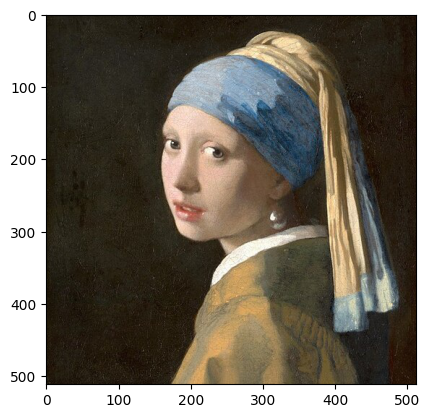

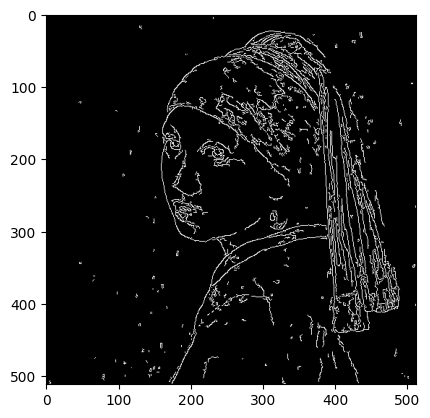

In [10]:
image = load_image("https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png")
image = np.array(image)


plt.figure()
plt.imshow(image)
plt.show()

canny_image = cv2.Canny(image, 100, 200)
canny_image = canny_image[:,:,None]
canny_image = np.concatenate([canny_image,canny_image,canny_image], axis = 2)
canny_image = Image.fromarray(canny_image)
plt.figure()
plt.imshow(canny_image)
plt.show()


## Use VQA/Image Captioning model (BLIP2) to derive prompts

In [11]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BlipProcessor, BlipForQuestionAnswering, pipeline
import torch


In [12]:
# image to text with vit-gpt2
torch.manual_seed(123)
image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

if(type(image) != Image.Image):
    image = Image.fromarray(image)
input_text = image_to_text(image)
input_text = input_text[0]['generated_text']

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
# image to text with blip2 --> OOM on local machine
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-6.7b-coco")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-6.7b-coco", torch_dtype=torch.float16)
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()


In [7]:
# VQA with Blip

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to("cuda")
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)

question = "An image of "
inputs = processor(image, question, return_tensors="pt").to("cuda")
out = model.generate(**inputs)
generated_text = processor.decode(out[0], skip_special_tokens=True)


input_text = question + generated_text





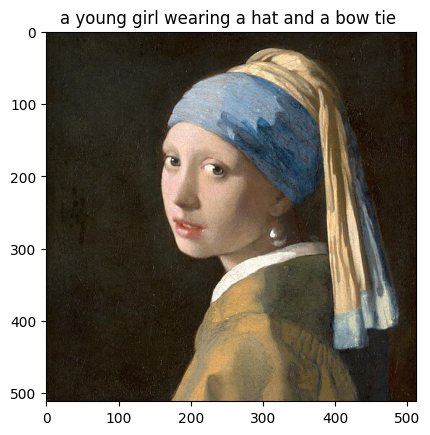

In [13]:
plt.figure()
plt.title(input_text)
plt.imshow(image)
plt.show()

## ControlNet + Text prompt to augment image

Loading pipeline components...:  57%|█████▋    | 4/7 [00:13<00:07,  2.58s/it]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


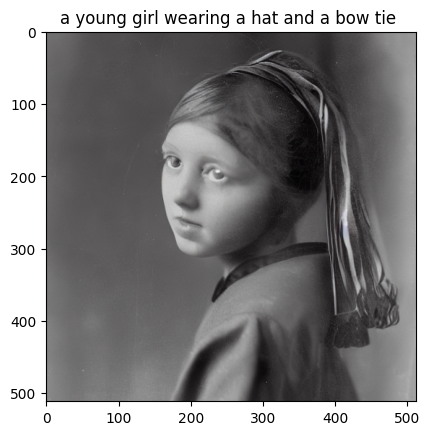

In [14]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload()
generator = torch.manual_seed(0)

images = pipe(input_text, num_inference_steps=20, generator=generator, image=canny_image).images
image = images[0]
plt.figure()
plt.title(input_text)
plt.imshow(image)
plt.show()

# ControlNet on COCO

In [1]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import numpy as np
import torch
import cv2
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BlipProcessor, BlipForQuestionAnswering, pipeline
import os
from pathlib import Path
device = "cuda" if torch.cuda.is_available() else "cpu"


/home/hansel/anaconda3/envs/mamba/envs/controlnet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
classes=['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
            'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
            'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
            'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
            'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
            'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
            'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
            'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
            'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
            'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
            'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
            'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
            'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
            'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'banner',
            'blanket', 'branch', 'bridge', 'building-other', 'bush', 'cabinet',
            'cage', 'cardboard', 'carpet', 'ceiling-other', 'ceiling-tile',
            'cloth', 'clothes', 'clouds', 'counter', 'cupboard', 'curtain',
            'desk-stuff', 'dirt', 'door-stuff', 'fence', 'floor-marble',
            'floor-other', 'floor-stone', 'floor-tile', 'floor-wood', 'flower',
            'fog', 'food-other', 'fruit', 'furniture-other', 'grass', 'gravel',
            'ground-other', 'hill', 'house', 'leaves', 'light', 'mat', 'metal',
            'mirror-stuff', 'moss', 'mountain', 'mud', 'napkin', 'net',
            'paper', 'pavement', 'pillow', 'plant-other', 'plastic',
            'platform', 'playingfield', 'railing', 'railroad', 'river', 'road',
            'rock', 'roof', 'rug', 'salad', 'sand', 'sea', 'shelf',
            'sky-other', 'skyscraper', 'snow', 'solid-other', 'stairs',
            'stone', 'straw', 'structural-other', 'table', 'tent',
            'textile-other', 'towel', 'tree', 'vegetable', 'wall-brick',
            'wall-concrete', 'wall-other', 'wall-panel', 'wall-stone',
            'wall-tile', 'wall-wood', 'water-other', 'waterdrops',
            'window-blind', 'window-other', 'wood']

def save_example(image, annotation, canny_image, augmentations, prompts, annotated_classes, folder, idx):
    fig,axs = plt.subplots(1,3+len(augmentations), figsize=(10+(5*len(augmentations)),15))
    axs[0].imshow(image)
    axs[1].imshow(annotation)
    axs[1].set_title(("\n").join(annotated_classes))
    axs[2].imshow(canny_image)
    for j, (augmented_image, prompt) in enumerate(zip(augmentations, prompts)):
        axs[j+3].imshow(augmented_image)
        axs[j+3].set_title(prompt)

    for ax in axs:
        ax.set_axis_off()

    str_idx = str(idx).zfill(4)
    save_dir = "./AugmentedImages/CocoStuff10k_Train/"+folder+"/"
    os.makedirs(save_dir, exist_ok = True)
    plt.tight_layout()
    plt.savefig(save_dir+str_idx+".jpg")
    plt.close()
    return 


In [8]:
image2text_model = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

vqa_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
vqa_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16)
controlnet_pipe.scheduler = UniPCMultistepScheduler.from_config(controlnet_pipe.scheduler.config)
controlnet_pipe.enable_model_cpu_offload()

def image2text(image, seed = 42):
    # image to text with vit-gpt2
    torch.manual_seed(seed)
    if(type(image) != Image.Image):
        image = Image.fromarray(image)
    input_text = image2text_model(image)
    input_text = input_text[0]['generated_text']
    return input_text

def vqa(image, seed = 42):
    torch.manual_seed(seed)
    question = "What is in the image?"
    inputs = vqa_processor(image, question, return_tensors="pt").to(device)
    out = vqa_model.generate(**inputs)
    generated_text = vqa_processor.decode(out[0], skip_special_tokens=True)
    input_text = "A photograph of" + generated_text
    return input_text

def augment_image_controlnet(image, canny_image, prompt, seed = 42):
    generator = torch.manual_seed(seed)
    images = controlnet_pipe(prompt, num_inference_steps=20, generator=generator, image=canny_image).images
    image = images[0]
    return image

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/hansel/anaconda3/envs/mamba/envs/controlnet/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Loading pipeline components...:  57%|█████▋    | 4/7 [00:00<00:00,  4.24it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100

In [7]:
prompt_definition = "vqa" #"alternating" #"vqa" "img2text" "annotations"
iterative_img = True

data_paths = glob("../mmsegmentation/data/coco_stuff10k/images/train2014/*.jpg")
annotations_dir = "../mmsegmentation/data/coco_stuff10k/annotations/train2014/"

save_number_images = 5
num_augmentations = 4
for img_idx, path in enumerate(data_paths): 
    if(img_idx == save_number_images):
        break

    init_image = np.array(Image.open(path))
    canny_image = cv2.Canny(init_image, 100, 250)
    canny_image = canny_image[:,:,None]
    canny_image = np.concatenate([canny_image,canny_image,canny_image], axis = 2)
    canny_image = Image.fromarray(canny_image)

    annotation_path = annotations_dir+Path(path).stem+"_labelTrainIds.png"
    annotation = np.array(Image.open(annotation_path))
    annotated_classes = [classes[x-1] for x in np.unique(annotation)]

    augmentations = []
    prompts = []
    image = init_image.copy()
    if(len(image.shape) != 3):
        image = np.stack([image,image,image], axis = 0)
    for i in range(num_augmentations):
        if(not iterative_img):
            image = init_image
        seed = torch.randint(high = 10000000, size = (1,))
        if(prompt_definition == "alternating"):
            if((i%2) == 0):
                prompt = image2text(image, seed)
            else: 
                prompt = vqa(image, seed)
        elif(prompt_definition == "vqa"):
            prompt = vqa(image, seed)
        elif(prompt_definition == "img2text"):
            prompt = image2text(image, seed)
        elif(prompt_definition == "annotations"):
            anno_str = " ".join(annotated_classes)
            prompt = "An image of "+anno_str
        image = augment_image_controlnet(image, canny_image, prompt, seed)
        augmentations.append(image)
        prompts.append(prompt+"\n Seed = "+str(float(seed)))
    save_example(init_image, annotation, canny_image, augmentations, prompts, annotated_classes, prompt_definition+"_"+str(iterative_img),img_idx)

    

/home/hansel/anaconda3/envs/mamba/envs/controlnet/lib/python3.11/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 20/20 [00:03<00:00,  5.19it/s]
/home/hansel/anaconda3/envs/mamba/envs/controlnet/lib/python3.11/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
/home/hansel/anaconda3/envs/mamba/envs/controlnet/lib/python3.11/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to cont

In [16]:
image = image[None,:,:]
image.shape

(1, 640, 512)

(3, 640, 512)

In [20]:
image = image.squeeze()

In [23]:
type(image)

numpy.ndarray